# 8.5.1 Medium: Apply the SARIMA(p,d,q)(P,D,Q)m model on the Johnson & Johnson dataset  

In chapter 7, we applied an ARIMA(p,d,q) model to the Johnson & Johnson dataset to forecast the quarterly EPS over a year.
Now, use the SARIMA(p,d,q)(P,D,Q)m model on the same dataset and compare its performance to the ARIMA model.  
• Use time series decomposition to identify the presence of a periodic pattern.  
• Use the optimize_SARIMA function and select the model with the lowest AIC.  
• Perform residual analysis.   
• Forecast the EPS for the last year and measure the performance against the ARIMA model. Use the MAPE. Is it better?

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

from matplotlib import pyplot as plt, dates as mdates, ticker as mticker
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# omd
import importlib
import sys

sys.path.append('../../My-Code/')

import timetools as tt

importlib.reload(tt)

<module 'timetools' from '../../My-Code/timetools.py'>

In [2]:
# Use time series decomposition to identify the presence of a periodic pattern.  

df = pd.read_csv('data/jj.csv')
df.index = pd.to_datetime(df['date'])
df.head()

,date,data
date,,
1960-01-01,1960-01-01,0.71
1960-04-01,1960-04-01,0.63
1960-07-02,1960-07-02,0.85
1960-10-01,1960-10-01,0.44
1961-01-01,1961-01-01,0.61


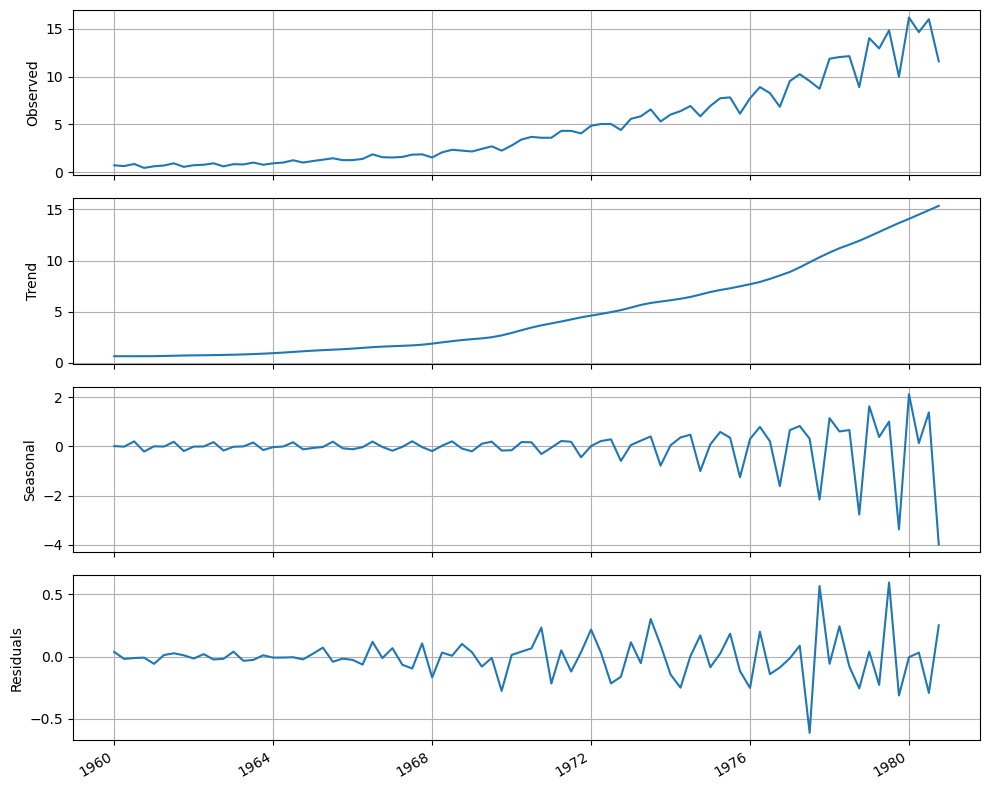

In [3]:
decomposition = STL(df['data'], period=4).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax1.grid(True)

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
ax2.grid(True)

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax3.grid(True)

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')
ax4.grid(True)

# plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH08_F04_peixeiro.png', dpi=300)

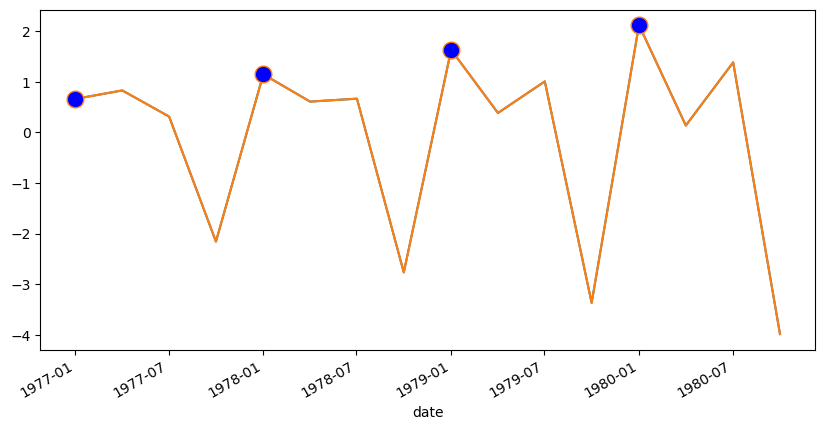

In [4]:
plt.figure(figsize=(10,5))
decomposition.seasonal.loc['1977': '1980'].plot()
plt.plot(decomposition.seasonal.loc['1977':'1980'], markevery=4, marker='o', markerfacecolor='blue', markersize=12)

### Use the optimize_SARIMA function and select the model with the lowest AIC. 

In [6]:
# stationary?

tt.adf_v2(df['data'])

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=0

Test Statistic                  2.742017
p-value                         1.000000
#Lags Used                     11.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64

The time series is not stationary.


In [8]:
tt.adf_v2(np.diff(df['data'], n=1))

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=0

Test Statistic                 -0.407410
p-value                         0.908854
#Lags Used                     10.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64

The time series is not stationary.


In [9]:
# stationary when d=1 ?

tt.adf_v2(df['data'], diff=1)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=1

Test Statistic                 -0.407410
p-value                         0.908854
#Lags Used                     10.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64

The time series is not stationary.


In [10]:
tt.adf_v2(np.diff(df['data'], n=2))

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=0

Test Statistic                 -3.585163
p-value                         0.006051
#Lags Used                      9.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64

The time series is stationary.


In [11]:
tt.adf_v2(df['data'], diff=2)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=2

Test Statistic                 -3.585163
p-value                         0.006051
#Lags Used                      9.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64

The time series is stationary.


In [12]:
tt.adf_v2(np.diff(df['data'], n=2))
# tt.adf(df['data'].diff(1).diff(1)[2:])

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=0

Test Statistic                 -3.585163
p-value                         0.006051
#Lags Used                      9.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64

The time series is stationary.


### The time series is not stationary after applying a 1-order differencing.  Therefore, let’s apply a seasonal difference and test for stationarity.

In [13]:
x = np.array([7, 8, 9, 3, 5, 8, 3, 5], dtype=float)
df_x = pd.DataFrame(x, columns=['x'])
df_x['x_diff_1'] = np.insert(np.diff(x, n=1), 0, np.nan)
df_x['x_diff_2'] = np.insert(np.diff(x, n=2), 0, [np.nan, np.nan])
df_x

,x,x_diff_1,x_diff_2
0,7.0,NaN,NaN
1,8.0,1.0,NaN
2,9.0,1.0,0.0
3,3.0,-6.0,-7.0
4,5.0,2.0,8.0
5,8.0,3.0,1.0
6,3.0,-5.0,-8.0
7,5.0,2.0,7.0


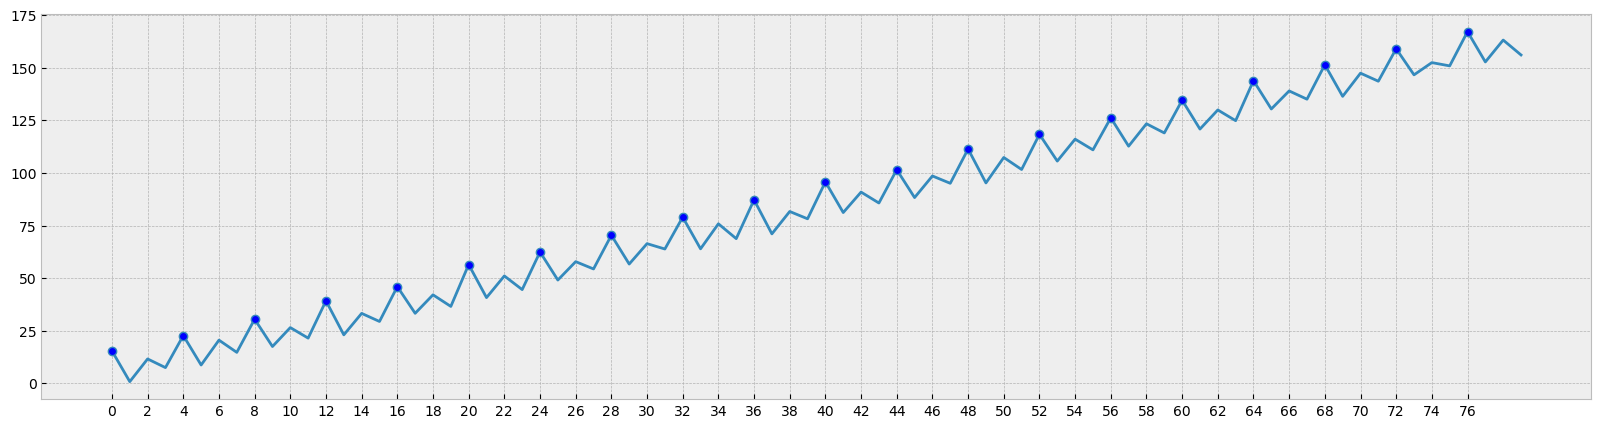

In [17]:
np.random.seed(42)
num = 20
seasonal = [15,-1,7,0] * num
trend = np.arange(0, len(seasonal), 1)
white_noise = np.random.standard_normal(len(trend))

y = trend + seasonal + white_noise

plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(20,5))
x = pd.Series(y+np.arange(len(y)))
ax.plot(x, markevery=4, marker='o', markerfacecolor='blue')
ax.set_xticks(np.arange(0, len(x), 4))
ax.xaxis.set_major_locator(mticker.FixedLocator(np.arange(0, 78, 2)))
plt.show()

In [18]:
tt.adf_v2(x)

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=0

Test Statistic                  0.376960
p-value                         0.980613
#Lags Used                     11.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64

The time series is not stationary.


Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=0

Test Statistic                 -3.957324
p-value                         0.001651
#Lags Used                     12.000000
Number of Observations Used    66.000000
Critical Value (1%)            -3.533560
Critical Value (5%)            -2.906444
Critical Value (10%)           -2.590724
dtype: float64

The time series is stationary.


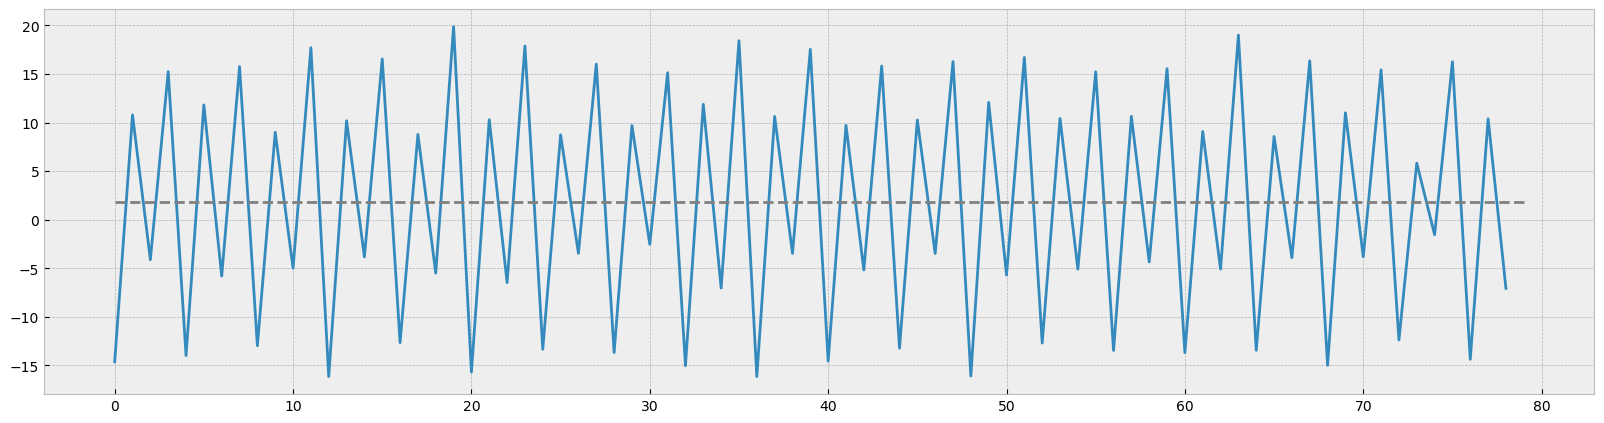

In [20]:
lags = 1
tt.adf_v2(np.diff(x, n=lags))
plt.figure(figsize=(20,5))
plt.plot(np.diff(x, n=lags))
plt.hlines(y=np.mean(np.diff(x, n=lags)), xmin=0, xmax=len(np.diff(x, n=lags)), 
    color='grey', ls='--')

Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

Differenced?  d=0

Test Statistic                -6.074175e+00
p-value                        1.131994e-07
#Lags Used                     9.000000e+00
Number of Observations Used    6.500000e+01
Critical Value (1%)           -3.535217e+00
Critical Value (5%)           -2.907154e+00
Critical Value (10%)          -2.591103e+00
dtype: float64

The time series is stationary.


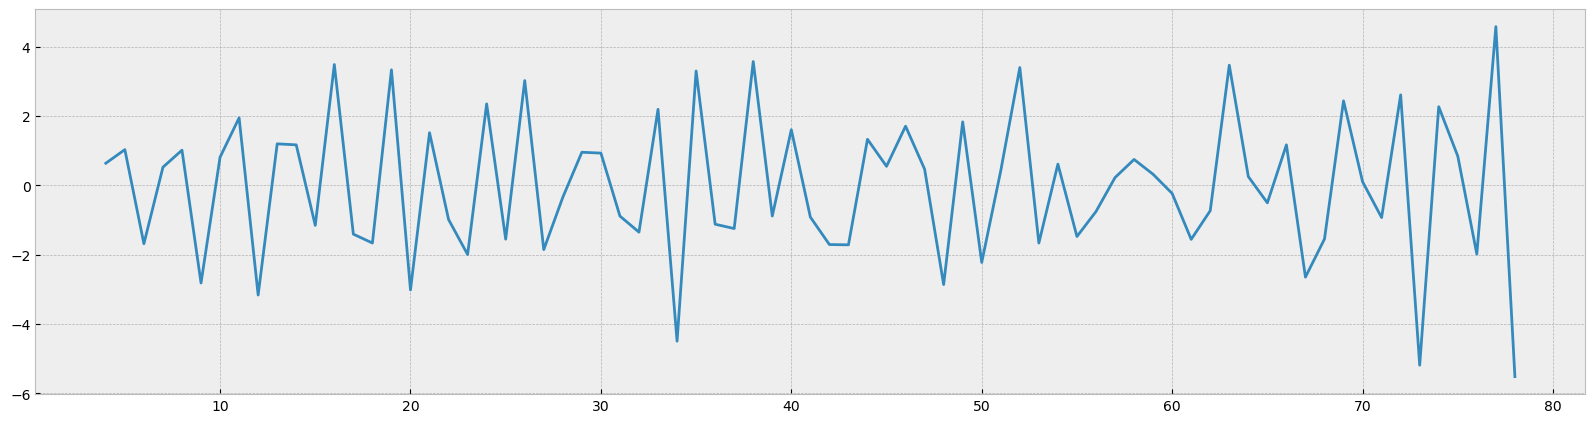

In [22]:
x_diff = np.diff(x, n=1)
x_diff_season = pd.DataFrame(x_diff).diff(4)[4:]     # see electronic page 199 of 222 where it's said: 
                                                 # "A Seasonal differencing. Since we have monthly data, m = 12, 
                                                 # so the seasonal difference is the difference between two values that are 12 timesteps apart."
                                                 # My approach seems to actually work since it applies a real seasonal differencing.
x_diff_season.columns = ['data']
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(x_diff_season['data'])
tt.adf_v2(x_diff_season['data'])

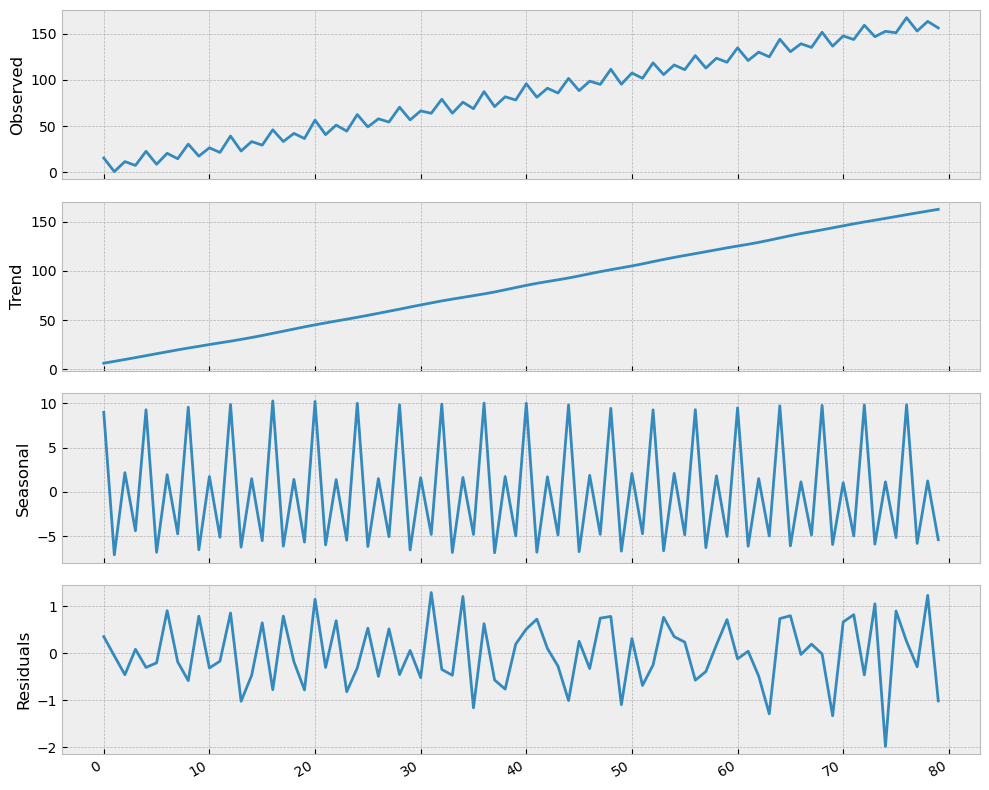

In [23]:
decomposition = STL(x, period=4).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')



fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
ps = range(0, 5, 1)
qs = range(0, 5, 1)
Ps = [0, 5, 1]
Qs = [0, 5, 1]

d = 1
D = 1
s = 4

ARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = x[:-4]

ARIMA_result_df = tt.optimize_SARIMA(train, ARIMA_order_list, d, D, s)
ARIMA_result_df

  0%|          | 0/225 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(0, 1, 0, 1)",220.459532
1,"(0, 1, 1, 1)",222.092754
2,"(0, 2, 0, 1)",222.196417
3,"(1, 1, 0, 1)",222.213894
4,"(2, 3, 0, 1)",223.008745
...,...,...
164,"(2, 0, 0, 0)",272.652705
165,"(3, 0, 0, 0)",273.901079
166,"(1, 0, 0, 0)",279.442836
167,"(0, 0, 1, 0)",279.522951


In [ ]:
train, test = x[:-4], pd.DataFrame(x[-4:])

SARIMA_model = SARIMAX(train, order=(0, 1, 1), seasonal_order=(0,1,1,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   76
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                -107.230
Date:                           Wed, 12 Jan 2022   AIC                            220.460
Time:                                   18:47:30   BIC                            227.248
Sample:                                        0   HQIC                           223.159
                                            - 76                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9100      0.091     -9.991      0.000      -1.088      -0.731
ma.S.L4       -0.9984     11.531     -0.087

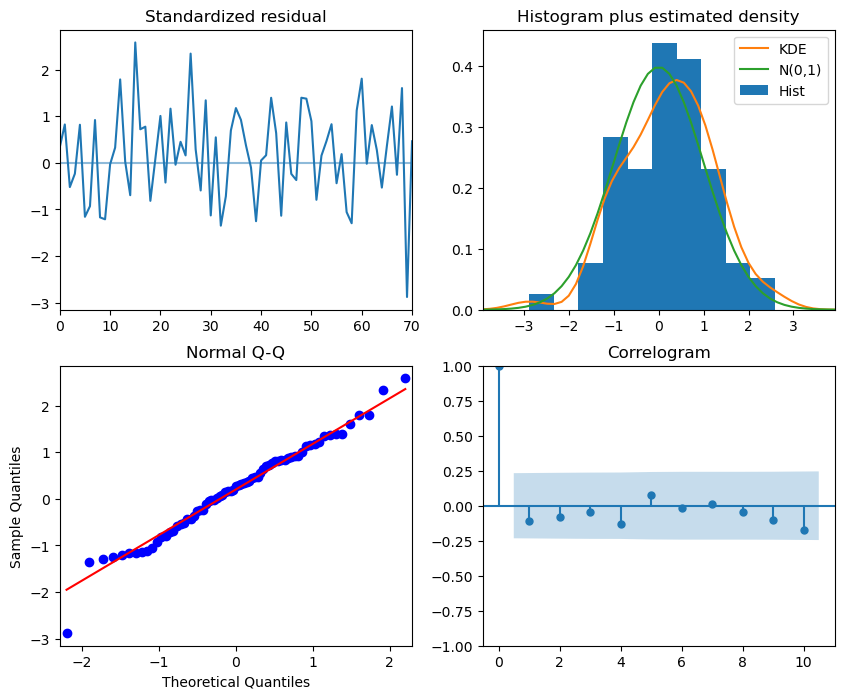

In [ ]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

# plt.savefig('figures/CH08_F12_peixeiro.png', dpi=300)

In [ ]:
residuals = SARIMA_model_fit.resid
residuals
# tt.ljungbox(residuals, lags=10)

0     15.496714
1    -14.634965
2     10.785927
3     -4.124647
4      7.494454
        ...    
71     1.226635
72    -0.258315
73     1.625781
74    -2.911877
75     0.470188
Length: 76, dtype: float64

In [ ]:
def ljungbox(residuals: np.array, lags=10):
    from statsmodels.stats.diagnostic import acorr_ljungbox

    lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, lags+1, 1))

    valnames = []

    for i in range(len(pvalue)):
        valnames.append('lag ' + str(i+1))

    plt.style.use('bmh')
    fig, ax = plt.subplots(figsize=(10,5))

    ax.bar(
        valnames, 
        pvalue, 
        width=0.4)

    ax.set_title('Ljung-Box test on the residuals for the first ' + str(len(pvalue)) + ' lags')
    ax.set_xlabel('Lags')
    ax.set_ylabel('p-values')
    ax.plot([-1, 10], [0.05, 0.05], "k--", color='gray')
    ax.set_ylim(0, 1.2)

    for index, value in enumerate(pvalue):
        plt.text(x=index, y=value + .05, s=str(round(value,2)), ha='center')

    print(min(pvalue))

    plt.tight_layout(); plt.style.use('default')

    if min(pvalue) >= 0.05:
        print('Minimum p-value: {0:0.2f} > 0.05'.format(min(pvalue)))
        print('The residuals are independent and not correlated.  Like white noise!')
    else:
        print('Minimum p-value: {0:0.2f} < 0.05'.format(min(pvalue)))
        print('The residuals are correlated.  Not good.')

index: 0, y: 1.0000000068273052, s: 0.0, ha: center
index: 1, y: 1.0000000000485136, s: 0.0, ha: center
index: 2, y: 1.0000000000198168, s: 0.0, ha: center
index: 3, y: 1.000000000038727, s: 0.0, ha: center
index: 4, y: 1.0000000001544147, s: 0.0, ha: center
index: 5, y: 1.0000000005447092, s: 0.0, ha: center
index: 6, y: 1.0000000017464252, s: 0.0, ha: center
index: 7, y: 1.000000004774792, s: 0.0, ha: center
index: 8, y: 1.0000000131521904, s: 0.0, ha: center
index: 9, y: 1.0000000334679588, s: 0.0, ha: center
1.9816880615121286e-11
Minimum p-value: 0.00 < 0.05
The residuals are correlated.  Not good.


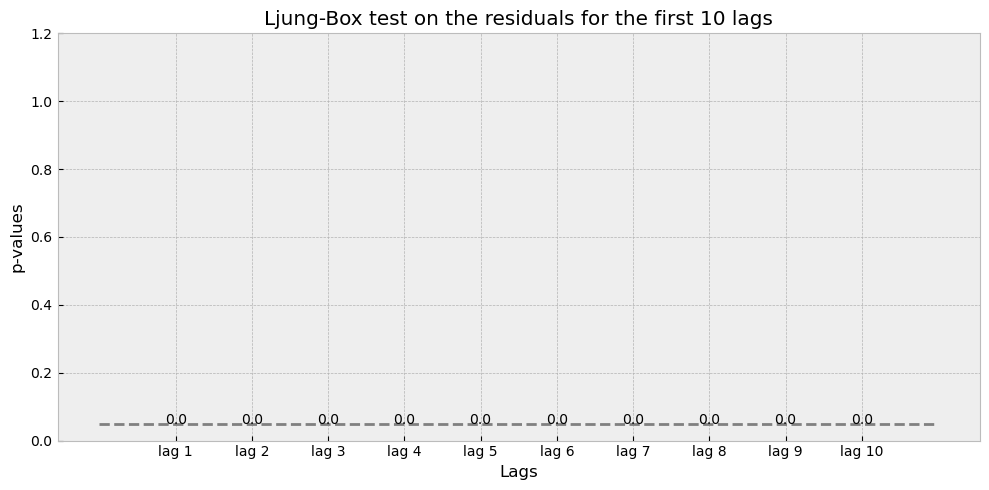

In [ ]:
ljungbox(residuals, lags=10)

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox 

residuals = SARIMA_model_fit.resid
lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1)) 
x = pd.DataFrame(pvalue, columns=['p-value'])
x['critical value'] = 0.05
x['p/f'] = ['pass' if i > 0.05 else 'fail' for i in x['p-value']]
x


,p-value,critical value,p/f
0,6.827305e-09,0.05,fail
1,4.851356e-11,0.05,fail
2,1.981688e-11,0.05,fail
3,3.872711e-11,0.05,fail
4,1.544146e-10,0.05,fail
5,5.447091e-10,0.05,fail
6,1.746425e-09,0.05,fail
7,4.774792e-09,0.05,fail
8,1.315219e-08,0.05,fail
9,3.346796e-08,0.05,fail


# Exercise

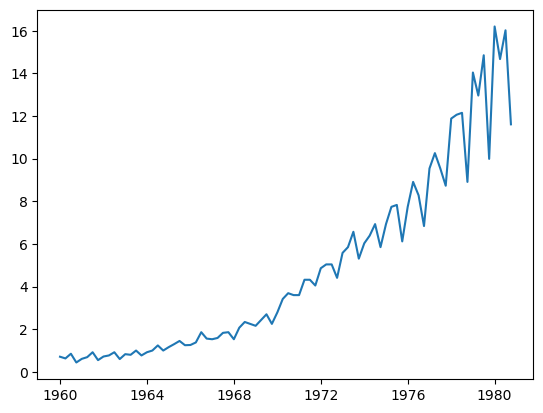

In [ ]:
plt.plot(df['data'])

Test Statistic                 -4.317044
p-value                         0.000415
#Lags Used                      5.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64

The time series is stationary.


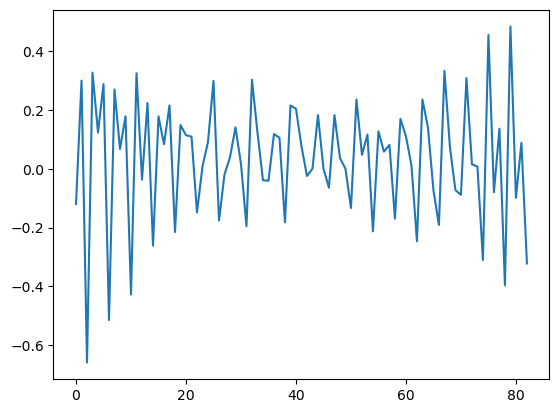

In [ ]:
df_diff1_log = np.diff(np.log(df['data']), n=1)
tt.adf(pd.Series(df_diff1_log))     
plt.plot(df_diff1_log)
plt.show()

Test Statistic                -6.032499e+00
p-value                        1.407057e-07
#Lags Used                     1.200000e+01
Number of Observations Used    6.600000e+01
Critical Value (1%)           -3.533560e+00
Critical Value (5%)           -2.906444e+00
Critical Value (10%)          -2.590724e+00
dtype: float64

The time series is stationary.


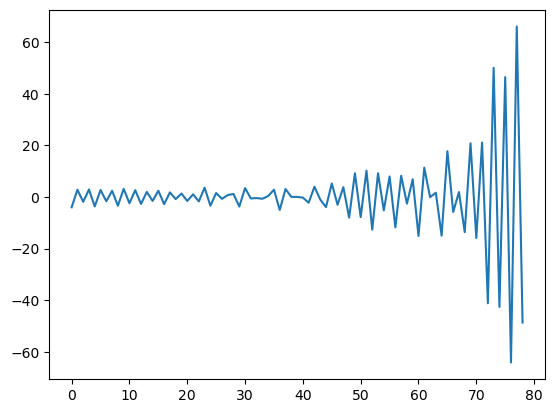

In [ ]:
df_diff1 = np.diff(df['data'], n=1)
df_diff_seasonal = np.diff(df_diff1, n=4)
tt.adf(pd.Series(df_diff_seasonal))     
plt.plot(df_diff_seasonal)
plt.show()

In [ ]:
ps = range(0, 5, 1) 
qs = range(0, 5, 1)
Ps = range(0, 5, 1)
Qs = range(0, 5, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs)) 

train = np.log(df['data'])[:-4] 
d=1 
D=0 
s = 4
SARIMA_result_df = tt.optimize_SARIMA(train, SARIMA_order_list, d, D, s) 

  0%|          | 0/625 [00:00<?, ?it/s]

In [ ]:
SARIMA_result_df

,"(p,q,P,Q)",AIC
0,"(0, 1, 2, 0)",-139.742068
1,"(0, 1, 1, 1)",-139.450670
2,"(0, 1, 3, 1)",-139.347967
3,"(2, 3, 2, 0)",-139.314410
4,"(0, 1, 1, 2)",-138.032440
...,...,...
436,"(1, 1, 0, 0)",-40.969743
437,"(2, 1, 0, 0)",-39.582016
438,"(2, 0, 0, 0)",-38.585028
439,"(1, 0, 0, 0)",-38.180805


In [ ]:
train, test = np.log(df['data'])[:-4], pd.DataFrame(df['data'][-4:])

SARIMA_model = SARIMAX(train, order=(0,1,1), seasonal_order=(2,0,0,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               data   No. Observations:                   80
Model:             SARIMAX(0, 1, 1)x(2, 0, [], 4)   Log Likelihood                  73.871
Date:                            Wed, 12 Jan 2022   AIC                           -139.742
Time:                                    19:19:23   BIC                           -130.264
Sample:                                         0   HQIC                          -135.945
                                             - 80                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6814      0.091     -7.517      0.000      -0.859      -0.504
ar.S.L4        0.6484      0.111   

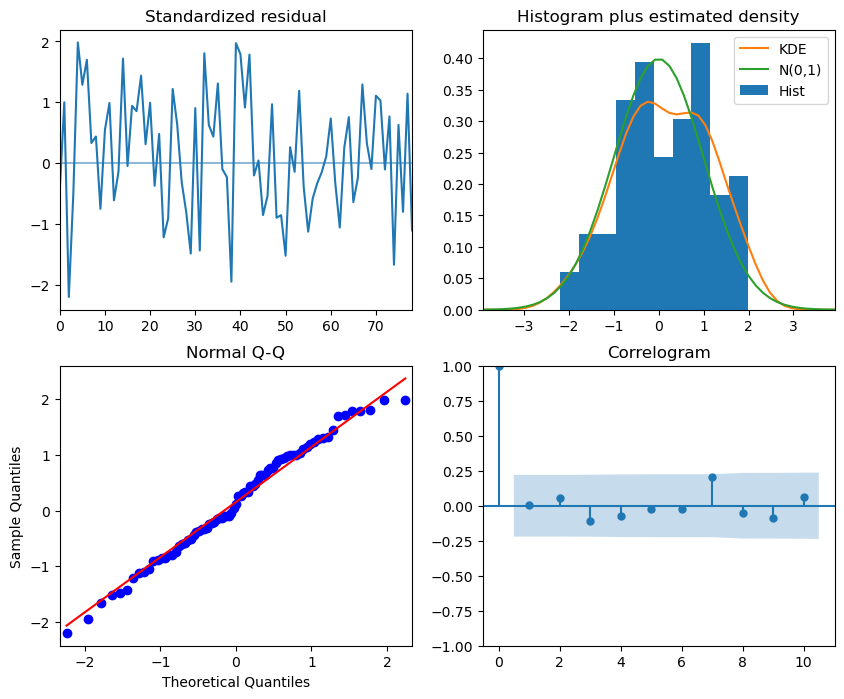

In [ ]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

# plt.savefig('figures/CH08_F12_peixeiro.png', dpi=300)

Minimum p-value: 0.67 > 0.05
The residuals are independent and not correlated.  Like white noise!


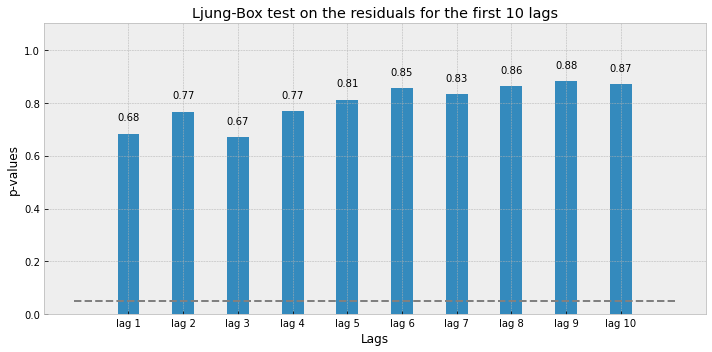

In [ ]:
residuals = SARIMA_model_fit.resid

tt.ljungbox(residuals, lags=10)

In [ ]:
import datetime

dti = pd.date_range("1979-12-01", periods=8, freq="Q")
dti

DatetimeIndex(['1979-12-31', '1980-03-31', '1980-06-30', '1980-09-30',
               '1980-12-31', '1981-03-31', '1981-06-30', '1981-09-30'],
              dtype='datetime64[ns]', freq='Q-DEC')

In [ ]:
test

,data,SARIMA_pred
date,,
1980-01-01,16.20,15.686361
1980-04-01,14.67,14.957516
1980-07-02,16.02,16.372779
1980-10-01,11.61,11.581735


In [ ]:
import datetime

SARIMA_pred = SARIMA_model_fit.get_prediction(80, 91).predicted_mean
SARIMA_pred.index = pd.date_range("1979-12-01", periods=12, freq="QS")
SARIMA_pred = np.exp(SARIMA_pred)

# test['SARIMA_pred'] = np.exp(SARIMA_pred.values)
# test

In [ ]:
SARIMA_pred

1980-01-01    15.686361
1980-04-01    14.957516
1980-07-01    16.372779
1980-10-01    11.581735
1981-01-01    17.684819
1981-04-01    16.757552
1981-07-01    18.478345
1981-10-01    13.173134
1982-01-01    19.733792
1982-04-01    18.797708
1982-07-01    20.554992
1982-10-01    14.941747
Freq: QS-JAN, dtype: float64

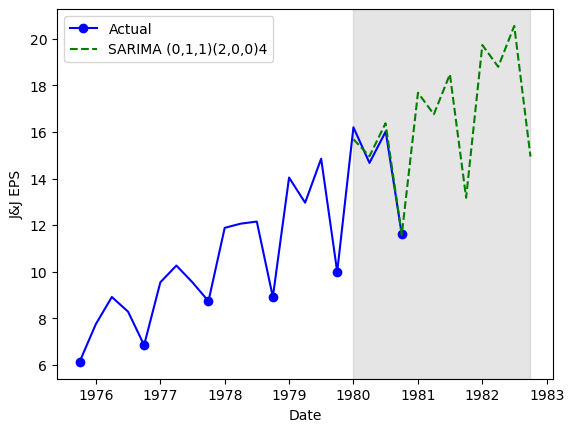

In [127]:
fig, ax = plt.subplots()

ax.plot(df.data.loc['1975-9':'1981'], label='Actual', color='blue', marker='o', markevery=4)
# ax.plot(test['SARIMA_pred'], color='green', label='SARIMA', ls='dashed')
ax.plot(SARIMA_pred, color='green', label='SARIMA (0,1,1)(2,0,0)4', ls='dashed')     

ax.set_xlabel('Date')
ax.set_ylabel('J&J EPS')
ax.axvspan('1980-01-01', '1982-10-01', color='#808080', alpha=0.2)
plt.legend()
plt.show()

In [94]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [95]:
# in order to run this run the following: 
# test['SARIMA_pred'] = np.exp(SARIMA_pred.values)
# where the number of predictions has to be "4"
mape_SARIMA = mape(test['data'], test['SARIMA_pred'])

print(mape_SARIMA)

1.8940180022233202


In [253]:
x = pd.DataFrame(SARIMA_pred, columns=['data'])

In [272]:
def create_lagged_df(df, lags):
    x = df.copy()
    for i in range(lags):
        shift = i +1
        x['lag'+str(shift)] = x.iloc[:,0].shift(periods=-shift)
    return x

In [276]:
y = tt.create_lagged_df(x, 12)
y

,data,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12
1980-01-01,15.686361,14.957516,16.372779,11.581735,17.684819,16.757552,18.478345,13.173134,19.733792,18.797708,20.554992,14.941747,NaN
1980-04-01,14.957516,16.372779,11.581735,17.684819,16.757552,18.478345,13.173134,19.733792,18.797708,20.554992,14.941747,NaN,NaN
1980-07-01,16.372779,11.581735,17.684819,16.757552,18.478345,13.173134,19.733792,18.797708,20.554992,14.941747,NaN,NaN,NaN
1980-10-01,11.581735,17.684819,16.757552,18.478345,13.173134,19.733792,18.797708,20.554992,14.941747,NaN,NaN,NaN,NaN
1981-01-01,17.684819,16.757552,18.478345,13.173134,19.733792,18.797708,20.554992,14.941747,NaN,NaN,NaN,NaN,NaN
1981-04-01,16.757552,18.478345,13.173134,19.733792,18.797708,20.554992,14.941747,NaN,NaN,NaN,NaN,NaN,NaN
1981-07-01,18.478345,13.173134,19.733792,18.797708,20.554992,14.941747,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-10-01,13.173134,19.733792,18.797708,20.554992,14.941747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982-01-01,19.733792,18.797708,20.554992,14.941747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982-04-01,18.797708,20.554992,14.941747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
